## Bitcoin Preview

### Introdução

Nesse projeto, vamos tentar prever o preço futuro das Bitcoins, baseados no histórico de valor da moeda. Vamos analizar alguns modelos e determinar qual tem a maior precisão. Os modelos que eu escolhi foram o Prophet, do Facebook, um modelo de regressão por tempo que foi feito exatamente para esse tipo de caso de uso. Vamos comparar o resultado com o XGBRegressor, que é um modelo de regressão com gradient boosting extremamente performático.

<img src='./images/bitcoin.jpg'>

### Importações

Aqui importamos algumas bibliotecas que vamos usar para preprocessamento dos dados e para fazermos a previsão de fato. O pandas vai nos ajudar a ler e manipular o nosso dataset com mais facilidade. fbprophet e xgboost são nossos dois modelos de machine learning e datetime vai nos ajudar a tratar datas dentro do nosso dataset. Além disso, também vamos usar o mean_absolute_error do sklearn para medir a precisão dos modelos e o train_test_split para dividir os dados antes de inserir no modelo de gradiente.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


### Conhecendo o dataset

Aqui lemos nosso dataset e damos uma olhada nele. O dataset, nesse caso, se trata de um compilado de transações com bitcoin por minuto desde 31/12/2011. Você pode baixar o modelo aqui: https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [37]:
data = pd.read_csv('bitstampUSD.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perceba que muitas linhas estão com valores nulos. Isso acontece em minutos em que não houveram transações ou movimentações. Nós vamos tratar disso em breve

### Pré-processamento

Aqui convertemos a coluna timestamp de string para timestamp de fato, o que vai ser importante para lidarmos com essas datas de forma precisa

In [38]:
data['Timestamp'] = [datetime.fromtimestamp(x) for x in data['Timestamp']]
data = data.set_index('Timestamp')
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 05:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 05:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 05:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 05:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 05:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Agora agrupamos os dados por dia, considerando um valor médio para o Bitcoin baseado no valor em cada minuto. 

In [39]:
data_daily = data.resample("24H").mean()
data_daily.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2020-12-26,25516.627794,25533.842373,25499.763960,25518.348337,5.329045,137540.407958,25516.571426
2020-12-27,27072.713715,27100.016486,27043.076375,27073.781333,9.371768,253842.005644,27070.852783
2020-12-28,26948.768243,26968.151917,26929.018049,26949.816292,5.209713,140469.943061,26948.937792
2020-12-29,26775.937271,26795.615687,26756.716583,26776.650569,7.099037,190052.578472,26777.002413
2020-12-30,28212.117145,28234.856582,28187.633743,28212.931245,8.320879,234983.919619,28211.436893


Agora tratamos dos valores nulos. Vamos determinar esse valores usando interpolação linear.

<img src='./images/interpolation.png' height=300px align="center">

Esse método funciona extremamente bem aqui porque, como estamos tratando de uma linha do tempo, nossos valores funcionam em ordem linear. Ou seja, temos nossos valores no eixo y e o tempo no eixo x. Sendo assim, usando interpolação linear, podemos chegar em um valor bem próximo do real

In [40]:
# fazemos isso para cada coluna do dataset
data_daily['Open'] = data_daily['Open'].interpolate()
data_daily['High'] = data_daily['High'].interpolate()
data_daily['Low'] = data_daily['Low'].interpolate()
data_daily['Close'] = data_daily['Close'].interpolate()
data_daily['Volume_(BTC)'] = data_daily['Volume_(BTC)'].interpolate()
data_daily['Volume_(Currency)'] = data_daily['Volume_(Currency)'].interpolate()
data_daily['Weighted_Price'] = data_daily['Weighted_Price'].interpolate()


Agora formatamos as colunas de acordo com a documentação do Prophet, que vai ser o primeiro modelo que vamos usar

In [41]:
pr_data = data_daily.reset_index()[['Timestamp', 'Weighted_Price']].rename({'Timestamp':'ds', 'Weighted_Price':'y'}, axis=1)
pr_data.head()

,ds,y
0,2011-12-31,4.471603
1,2012-01-01,4.806667
2,2012-01-02,5.000000
3,2012-01-03,5.252500
4,2012-01-04,5.259343


Agora vamos separar alguns dados para treino do modelo e outros para teste

In [42]:
split_date = '2020-01-01'
train_date = pr_data['ds'] <= split_date
test_date = pr_data['ds'] > split_date

train_pr = pr_data[train_date]
test_pr = pr_data[test_date]

### Primeiro Modelo: Prophet

Agora que separamos os dados, vamos inserir os dados de treino no modelo

In [66]:
model_pr = Prophet()
model_pr.fit(train_pr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Com esse comando, pedimos para o Prophet fazer uma projeção do nosso dataframe para 364 dias, exatamente o mesmo período do nosso set de dados de teste

In [67]:
future_dates = model_pr.make_future_dataframe(periods=364)
future_dates.tail()

,ds
3283,2020-12-26
3284,2020-12-27
3285,2020-12-28
3286,2020-12-29
3287,2020-12-30


Agora vamos fazer a previsão de fato!

In [68]:
forecast = model_pr.predict(future_dates)

### Resultados: Prophet

Para visualizarmos melhor a previsão do Prophet, podemos criar alguns gráficos com os resultados

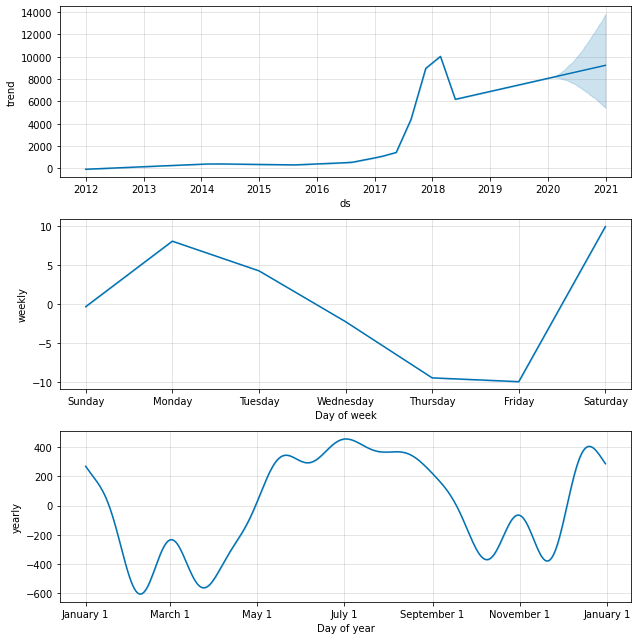

In [69]:
graph = model_pr.plot_components(forecast)

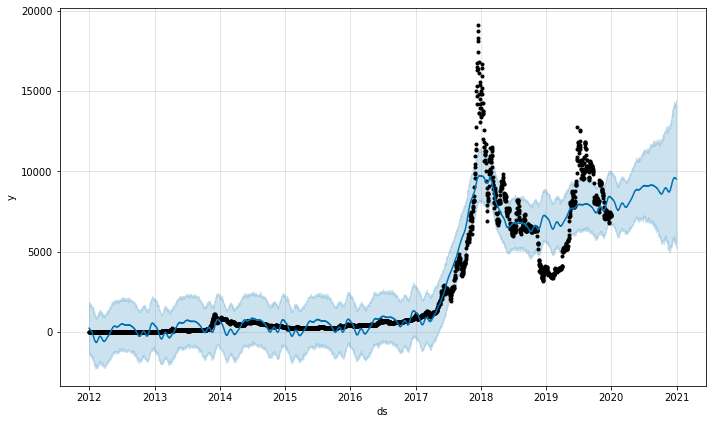

In [70]:
other_graph = model_pr.plot(forecast)

### Precisão: Prophet

Para avaliarmos a precisão do nosso modelo, vamos separar os dados para que eles estejam no mesmo formato e tamanho. No caso, precisamos de duas listas de 364 linhas, cada uma correspondente a um dia e com um valor de previsão do Prophet para o Bitcoin. Podemos aproveitar a variável de split_date que usamos para separar os dados de treino e de teste

In [71]:
y_pred_dates = forecast['ds'] > split_date
y_pred_parsed = forecast[y_pred_dates]
y_pred = y_pred_parsed['yhat'] 
y_true = test_pr['y']

Agora vamos calcular o erro médio absoluto para entender qual a precisão do nosso modelo.

In [72]:
score_pr = mean_absolute_error(y_true, y_pred)
print(score_pr)

2791.8658560547033


O erro médio absoluto do Prophet foi de, aproximadamente, $2800.00, o que é um valor bem aceitável para os valores que estamos analisando.

### Segundo Modelo: XGBRegressor

Para nosso segundo modelo, precisamos separar nossos dados de outra maneira. Vamos usar a função de train_test_split do Sklearn para separarmos os dados.

In [96]:
X = pr_data['ds']
y = pr_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Antes de colocar nossos dados no modelo, precisamos ajustar o formato do nosso array para que o modelo seja capaz de interpreta-los. Esse modelo espera um array de duas dimensões (linhas e colunas). Como só temos uma dimensão nesses arrays (as linhas), precisamos fazer um "remendo" de uma coluna para que o modelo seja capaz de ler nosso array

In [98]:
X_train = X_train[:,np.newaxis]
X_test = X_test[:,np.newaxis]

Agora vamos criar uma instancia do modelo para inserirmos os valores. Ele aceita alguns parametros como numero de estimadores, que determina o número de "voltas" que o modelo faz e a taxa de aprendizado do modelo. Também podemos definir uma parada antecipada, caso nosso modelo não consiga mais diminuir a taxa de perda.

In [99]:
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
model_xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
prediction_xgb = model_xgb.predict(X_test)

### Precisão: XGBRegressor

Vamos avaliar a performance do XGBRegressor, usando a mesma métrica de erro absoluto médio

In [101]:
score_xgb = mean_absolute_error(prediction_xgb, y_test)
print(score_xgb)

88.93156969182039


### Conclusão

O modelo de Regressão Gradiente deu um resultado de erro medio de menos de $90.00, o que é um resultado bem mais desejável e confiável do que o do Prophet. Como foi dito antes, o modelo de gradiente tem uma performance de ponta por se "aperfeiçoar" automaticamente a cada ciclo, buscando diminuir a taxa de perda até o mínimo possível.